# HealthLine Case Study
**Varun Divi**

## Imports

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Data Loading

In [235]:
data = pd.read_excel('Data_Analytics_Take_Home_HL_repaired.xlsx')

In [236]:
# Creating a new column which representing asset loading time and the users start time
data['time_difference'] = data['asset_loaded_time'] - data['session_start_time']
data_no_conversion = data[data['Conversion']==0]
data_conversion = data[data['Conversion']==1]

## Variable Analysis
* Before creating models to evaluate ideal combinations, each variable's importance will be evaluated. This is important to avoid uncessary clutter and poor predictors
* ID Variables are not used regardless

#### Known Diagnosis
Summary: Known diagnosis is an unrelable variable to collect evidenced by the overwhelming number of empty cell values. 
* I also acknowledge that known diagnosis is very valuable user information that may give us insight as to what specific webpages we should reccomend.
* **However**, in this context, we are trying to find which assets to display to the user to maximize conversion. The known diagnosis may have very high dependence on page_topic_description because of the nature of the variable. 
* For this reason, it might not make sense to include it as a predictor

In [237]:
# We can see the data imbalance across both succesfull and unsuccesfull conversions
print(data_no_conversion['known_diagnosis'].value_counts())
print(data_conversion['known_diagnosis'].value_counts())

known_diagnosis
                      79186
Breast Cancer          2914
Ulcerative Colitis     2197
Depression             1729
Migraine               1578
Crohns Disease         1420
Name: count, dtype: int64
known_diagnosis
                      9691
Ulcerative Colitis     326
Breast Cancer          239
Crohns Disease         235
Migraine               208
Depression             135
Name: count, dtype: int64


In [238]:
# Conversion Rate
data.groupby('known_diagnosis')['Conversion'].mean().sort_values(ascending=False)

known_diagnosis
Crohns Disease        0.141994
Ulcerative Colitis    0.129211
Migraine              0.116461
                      0.109038
Breast Cancer         0.075801
Depression            0.072425
Name: Conversion, dtype: float64

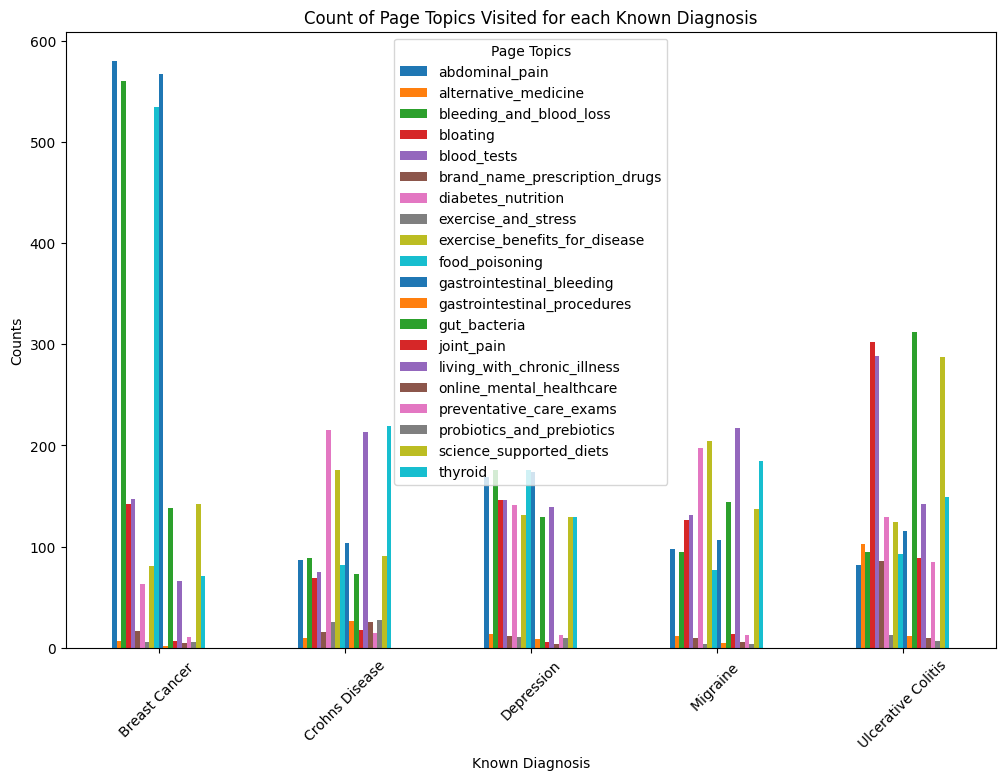

In [239]:
only_knowns = data[data['known_diagnosis'] != ' ']
grouped_counts = only_knowns.groupby(['known_diagnosis', 'page_topic_description']).size().unstack()
grouped_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Count of Page Topics Visited for each Known Diagnosis')
plt.xlabel('Known Diagnosis')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Page Topics')
plt.show()

#### Page Category
Summary: Similar to known_diagnosis, page_category may be too broad of a variable which has a high dependence with page_topic_description. 
* Looking at the bar plot below, we see that each category has a unique set of page_topic_descriptions, understandbly. 
* It wouldnt make sense to use both page_category and page_topic_description
* Assuming that we can use real-time decision making, it would make more sense to make a decision once we know the user's page_topic_description as it is more specific

In [240]:
# Conversion Rate
data.groupby('page_category')['Conversion'].mean().sort_values(ascending=False)

page_category
crohnsdisease                    0.457952
ulcerativecolitis                0.356527
otherinflammatoryboweldisease    0.180620
nauseaandvomiting                0.064373
otherdigestiveproblems           0.027849
Name: Conversion, dtype: float64

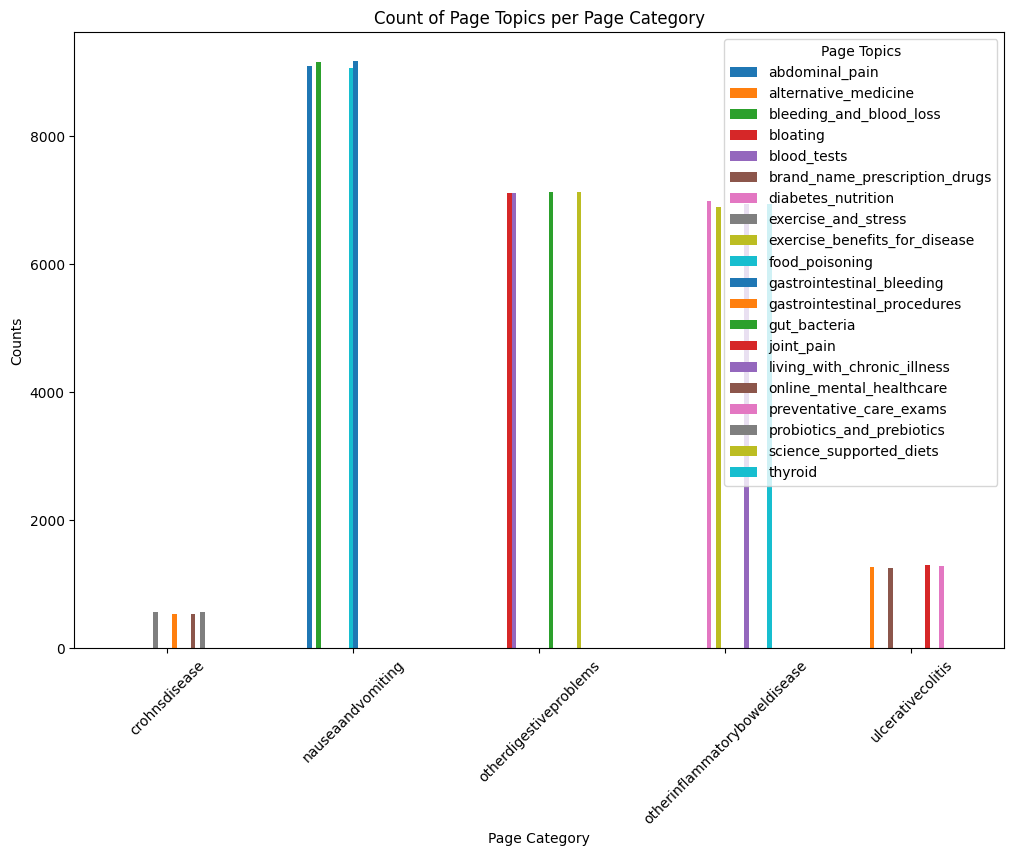

In [241]:
grouped_counts = data.groupby(['page_category', 'page_topic_description']).size().unstack()
grouped_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Count of Page Topics per Page Category')
plt.xlabel('Page Category')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Page Topics')
plt.show()

#### Device Type
Summary: I believe that Device Type would be important when deciding which asset to show to the user.
* Each Asset A,B,C have very different interfaces that the user sees. The nature of these Assets means that the device they use to see this asset makes a difference.
* For example, if a user was using a mobile device, it would make more sense to display a simple advertisement rather than a quiz which may not be mobile-friendly.


In [242]:
# Conversion Rate
data.groupby('Device_Type')['Conversion'].mean().sort_values(ascending=False)

Device_Type
mobile     0.111817
tablet     0.109714
desktop    0.107749
Name: Conversion, dtype: float64

#### Page Topic Description
Summary: Page Topic Description seems the be the most concise descriptor of the user's interest in the website. It is definitely one of the most important predictors

In [243]:
# Conversion Rate
data.groupby('page_topic_description')['Conversion'].mean().sort_values(ascending=False)

page_topic_description
gastrointestinal_procedures      0.488593
online_mental_healthcare         0.473384
exercise_and_stress              0.437828
probiotics_and_prebiotics        0.435398
joint_pain                       0.372291
preventative_care_exams          0.356474
alternative_medicine             0.354839
brand_name_prescription_drugs    0.342084
exercise_benefits_for_disease    0.187337
diabetes_nutrition               0.184003
thyroid                          0.176818
living_with_chronic_illness      0.174352
bleeding_and_blood_loss          0.069252
gastrointestinal_bleeding        0.066339
food_poisoning                   0.061686
abdominal_pain                   0.060156
blood_tests                      0.030512
gut_bacteria                     0.029610
science_supported_diets          0.026655
bloating                         0.024617
Name: Conversion, dtype: float64

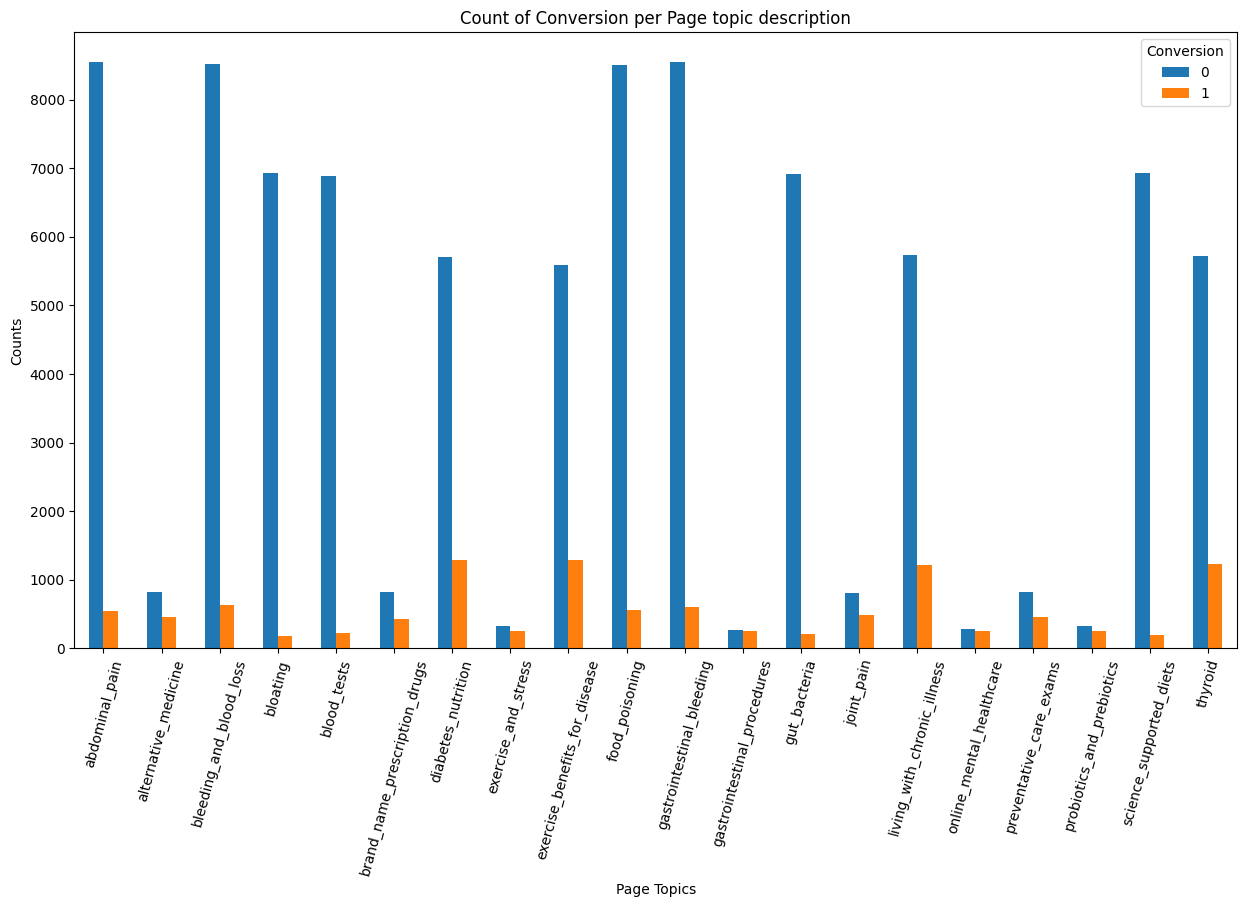

In [244]:
grouped_counts = data.groupby(['page_topic_description', 'Conversion']).size().unstack()
grouped_counts.plot(kind='bar', figsize=(15, 8))
plt.title('Count of Conversion per Page topic description')
plt.xlabel('Page Topics')
plt.ylabel('Counts')
plt.xticks(rotation=75)
plt.legend(title='Conversion')
plt.show()

#### Time Difference
Summary: Despite the results of the logistic regression, it will be very difficult to use a continuous variable with categorical variables, especially if one-hot-encoding is used. 
* The logistic regression suggests that there is a very high positive correlation between the odds of a conversion and the time difference. 
    * It is important to pay attention to the scale of time difference.
    * We can see that the distribution of actual time_difference is very small, therefore it may be a counfounding conclusion when we measure the impact that increasing time_difference by 1 has on Conversion. 

In [245]:
import statsmodels.api as sm

predictor_constant = sm.add_constant(data['time_difference'])
model = sm.Logit(data['Conversion'], predictor_constant).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.332926
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             Conversion   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99998
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 0.03782
Time:                        10:15:40   Log-Likelihood:                -33293.
converged:                       True   LL-Null:                       -34601.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.1351      0.024   -131.176      0.000      -3.182      -3.088
time_differenc

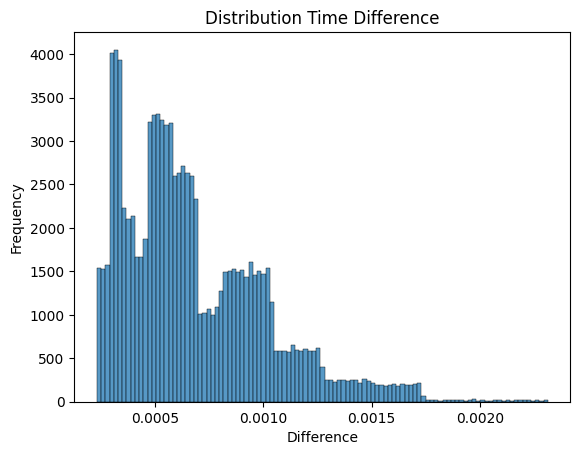

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data['time_difference'])
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution Time Difference')
plt.show()

#### Return Visitor
Summary: The data imbalance of this variable suggests that it might be a poor predictor. Despite the value in a returning customer, this variable does not appear to be a good predictor

In [247]:
# Conversion Rate
data.groupby('Return Visitor')['Conversion'].mean().sort_values(ascending=False)

Return Visitor
1    0.236516
0    0.084947
Name: Conversion, dtype: float64

In [248]:
print(data['Return Visitor'].value_counts())

Return Visitor
0    83629
1    16371
Name: count, dtype: int64


#### Time of Day
Summary: The time of Day seems to have little to no impact on conversion rate. The distribution of time visited is also very consistent.

In [249]:
# Conversion Rate
data.groupby('time of day')['Conversion'].mean().sort_values(ascending=False)

time of day
4     0.119180
17    0.117675
9     0.115036
15    0.114443
7     0.114191
1     0.113065
16    0.112800
18    0.111803
3     0.111591
22    0.111111
20    0.110438
13    0.110416
12    0.110094
19    0.109747
21    0.108807
2     0.107143
11    0.106383
10    0.105976
23    0.105646
0     0.105197
5     0.104833
14    0.104381
6     0.102545
8     0.101483
Name: Conversion, dtype: float64

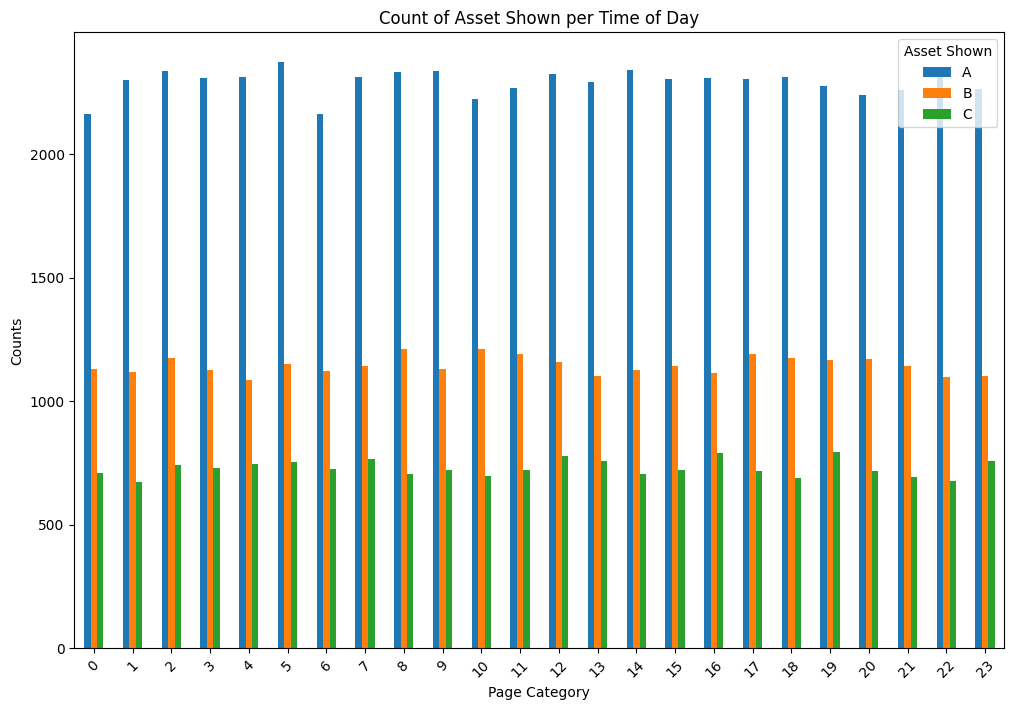

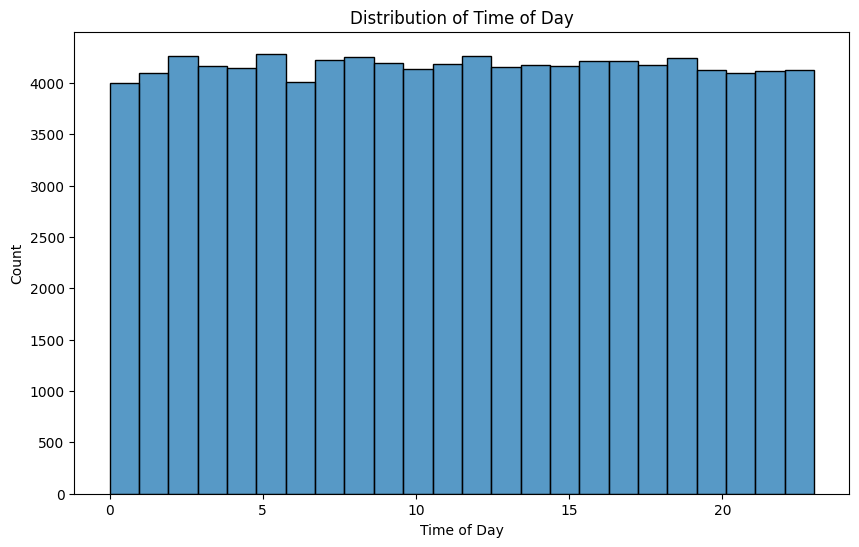

In [250]:
grouped_counts = data.groupby(['time of day', 'Asset Shown']).size().unstack()

grouped_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Count of Asset Shown per Time of Day')
plt.xlabel('Page Category')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Asset Shown')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data['time of day'], bins=24)  # 24 bins for 24 hours
plt.title('Distribution of Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.show()

#### Asset Conversion Rate

In [251]:
data.groupby('Asset Shown')['Conversion'].mean().sort_values(ascending=False)

Asset Shown
C    0.170571
A    0.109655
B    0.071273
Name: Conversion, dtype: float64

### Descriptive Statistics


#### Statistic Functions

In [252]:
def calculate_conversion_rate(data, column_name):
    conversions = data[data['Conversion'] == 1].groupby(['Asset Shown', column_name])['Conversion'].count()
    
    total_shown = data.groupby(['Asset Shown', column_name])['Conversion'].count()
    
    conversion_rate = (conversions / total_shown)
    
    sorted_conversion_rate = conversion_rate.sort_values(ascending=False)
    print(sorted_conversion_rate)
    print('\n')

    
def calculate_revenue(data, column_name):
    converted_data = data[data['Conversion'] == 1]
    asset_revenues = np.array([5, 7, 2.5])
    conversions_temp = converted_data.groupby([column_name, 'Asset Shown'])
    conversions_table = conversions_temp.size().reset_index(name='counts')
    conversions = conversions_temp.size().to_numpy()
    repeated_revenues = np.tile(asset_revenues, int(np.ceil(len(conversions)/len(asset_revenues))))[:len(conversions)]
    total_revenue = conversions * repeated_revenues
    sum(total_revenue)
    conversions_table = conversions_temp.size().reset_index(name='counts')
    conversions_table['Revenue'] = total_revenue
    revenue_by_column = conversions_table.groupby(column_name)['Revenue'].sum().reset_index().sort_values(by='Revenue', ascending=False)
    return revenue_by_column, conversions_table

### Calculating Conversion rate by Asset

##### Device Type
Asset C appears to have an overwhelmingly significant conversion rate across all platforms.

In [253]:
calculate_conversion_rate(data, 'Device_Type')

Asset Shown  Device_Type
C            desktop        0.174948
             mobile         0.170133
             tablet         0.166723
A            mobile         0.113195
             tablet         0.111105
             desktop        0.104710
B            mobile         0.072032
             desktop        0.071709
             tablet         0.070062
Name: Conversion, dtype: float64




#### Page Topic
* Asset C demonstrates consistent conversion. 
* Gastrointestinal_procedure also demonstrates consistently high conversion rates across all assets.
* Excercise and stress has a particularly high conversion rate for Asset C

In [254]:
calculate_conversion_rate(data, 'page_topic_description')

Asset Shown  page_topic_description       
C            gastrointestinal_procedures      0.583333
             online_mental_healthcare         0.568627
             exercise_and_stress              0.555556
             joint_pain                       0.546512
             alternative_medicine             0.489691
             brand_name_prescription_drugs    0.485714
             probiotics_and_prebiotics        0.471910
A            gastrointestinal_procedures      0.469965
B            gastrointestinal_procedures      0.462585
             online_mental_healthcare         0.462069
C            preventative_care_exams          0.450262
A            online_mental_healthcare         0.444444
             probiotics_and_prebiotics        0.431818
             exercise_and_stress              0.431250
B            probiotics_and_prebiotics        0.422619
             exercise_and_stress              0.394118
A            joint_pain                       0.373494
             preventat

#### Revenue Generation By Asset and Total

##### Page Topic
* We can see that diabetes_nutrition is among the higher revenue generating pages
* Interestingly, the pages with high conversion rates are generating lower revenue.
    * This might have something to do with the frequency of Asset type on these pages. Asset A appears much more often

In [255]:
calculate_revenue(data, 'page_topic_description')

(           page_topic_description  Revenue
 6              diabetes_nutrition   7262.0
 8   exercise_benefits_for_disease   7261.0
 14    living_with_chronic_illness   5975.5
 19                        thyroid   5050.0
 10      gastrointestinal_bleeding   3593.0
 9                  food_poisoning   3293.0
 2         bleeding_and_blood_loss   2622.0
 13                     joint_pain   2448.0
 16        preventative_care_exams   2318.0
 1            alternative_medicine   2301.5
 0                  abdominal_pain   2292.5
 5   brand_name_prescription_drugs   2286.5
 11    gastrointestinal_procedures   1381.0
 7             exercise_and_stress   1358.5
 17      probiotics_and_prebiotics   1267.0
 15       online_mental_healthcare   1234.0
 18        science_supported_diets   1136.0
 3                        bloating   1039.0
 12                   gut_bacteria   1031.5
 4                     blood_tests    812.5,
            page_topic_description Asset Shown  counts  Revenue
 0         

##### Device Type
* Revenue is consistent across all platforms

In [256]:
calculate_revenue(data, 'Device_Type')

(  Device_Type  Revenue
 1      mobile  17500.0
 2      tablet  17054.0
 0     desktop  16783.5,
   Device_Type Asset Shown  counts  Revenue
 0     desktop           A    1932   9660.0
 1     desktop           B     658   4606.0
 2     desktop           C    1007   2517.5
 3      mobile           A    2070  10350.0
 4      mobile           B     665   4655.0
 5      mobile           C     998   2495.0
 6      tablet           A    2029  10145.0
 7      tablet           B     637   4459.0
 8      tablet           C     980   2450.0)

## Modelling

### Addressing Data Imbalance

In [257]:
def reshuffle_data(data):
    majority_class = data[data['Conversion'] == 0]
    minority_class = data[data['Conversion'] == 1]

    # Undersample the rows of no conversion
    majority_class_undersampled = majority_class.sample(len(minority_class), random_state=13)

    # Concatenate the randomly sampled rows
    balanced_data = pd.concat([majority_class_undersampled, minority_class], axis=0)

    # shuffle the rows
    balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
    return balanced_data

### Logistic Regression

A Logistic Regression model will be use to assess the most important variables resulting in a conversion.
* The Variables Used: Device Type
* Through trial and error, I noticed that inclusion of only these variables lead to a higher model accuracy.

Summary of Performance:
The performance of the Logistic Regression model across all three Assets appears to perform with an accuracy of roughly 0.7 and a ROC of 0.74. This suggests that while the model is able to make distinctions beyond guessing, there is still room to improve the model.

In [258]:
def create_predictors(data, cols):
    encoder = OneHotEncoder()
    balanced_data = reshuffle_data(data)
    X_uncoded = balanced_data[cols]
    y = balanced_data['Conversion']
    X = pd.get_dummies(X_uncoded, columns=X_uncoded.columns).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def create_filtered_predictors(data, filter_col, filter_cat):
    encoder = OneHotEncoder()
    balanced_data = reshuffle_data(data)
    balanced_data = balanced_data[balanced_data[filter_col] == filter_cat]
    X_uncoded = balanced_data[['Device_Type', 'page_topic_description']]
    y = balanced_data['Conversion']
    X = pd.get_dummies(X_uncoded, columns=X_uncoded.columns).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(X_uncoded.columns)
    return X_train, X_test, y_train, y_test

def create_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression()

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, predictions))
    print(f'ROC AUC Score: {roc_auc_score(y_test, probabilities)}')
    return model

def find_coefficients(data, filter_col, filter_cat):
    X_train = create_filtered_predictors(data, filter_col='Asset Shown', filter_cat='A')[0]
    log_model = create_model(*create_filtered_predictors(data, filter_col='Asset Shown', filter_cat='A'))
    coefficients = pd.DataFrame(log_model.coef_[0], index=X_train.columns, columns=['Coefficient'])
    coefficients['Odds_Ratio'] = np.exp(coefficients['Coefficient'])

    sorted_coefficients = coefficients.sort_values(by='Odds_Ratio', ascending=False)
    
    top_bottom_coefficients = pd.concat([sorted_coefficients.head(3), sorted_coefficients.tail(3)])
    
    print(f"\nTop and Bottom Coefficients with {filter_col} == {filter_cat}")
    return top_bottom_coefficients, log_model



### Evaluating Important Predictors by Asset
* I decided to display only the top 3 and bottom 3 predictors for each Asset

#### Asset A
* Important factors: Gastrointestinal, probiotics, exercise
* Weak Predictors: Blood tests, Bloating, Supporting Diets

In [259]:
find_coefficients(data, filter_col='Asset Shown', filter_cat='A')[0]

Index(['Device_Type', 'page_topic_description'], dtype='object')
Index(['Device_Type', 'page_topic_description'], dtype='object')
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1169
           1       0.70      0.71      0.71      1234

    accuracy                           0.70      2403
   macro avg       0.70      0.69      0.69      2403
weighted avg       0.70      0.70      0.70      2403

ROC AUC Score: 0.7424643650878379

Top and Bottom Coefficients with Asset Shown == A


,Coefficient,Odds_Ratio
page_topic_description_probiotics_and_prebiotics,1.680158,5.366404
page_topic_description_gastrointestinal_procedures,1.481522,4.399638
page_topic_description_online_mental_healthcare,1.312428,3.715182
page_topic_description_gut_bacteria,-1.774151,0.169627
page_topic_description_science_supported_diets,-1.872730,0.153704
page_topic_description_bloating,-1.874656,0.153408


#### Asset B
* Important factors: Gastrointestinal, probiotics, mental health
* Weak Predictors: science supported diets, blood tests, bloating

In [260]:
find_coefficients(data, filter_col='Asset Shown', filter_cat='B')[0]

Index(['Device_Type', 'page_topic_description'], dtype='object')
Index(['Device_Type', 'page_topic_description'], dtype='object')
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1155
           1       0.71      0.72      0.72      1248

    accuracy                           0.70      2403
   macro avg       0.70      0.70      0.70      2403
weighted avg       0.70      0.70      0.70      2403

ROC AUC Score: 0.7466946248196248

Top and Bottom Coefficients with Asset Shown == B


,Coefficient,Odds_Ratio
page_topic_description_probiotics_and_prebiotics,1.578406,4.847222
page_topic_description_gastrointestinal_procedures,1.518707,4.566317
page_topic_description_exercise_and_stress,1.349308,3.854758
page_topic_description_blood_tests,-1.756156,0.172708
page_topic_description_bloating,-1.862936,0.155216
page_topic_description_science_supported_diets,-1.881072,0.152427


#### Asset C
* Important factors: Gastrointestinal, probiotics, mental health
* Weak Predictors: science supported diets, depression, blood test

In [261]:
find_coefficients(data, filter_col='Asset Shown', filter_cat='C')[0]

Index(['Device_Type', 'page_topic_description'], dtype='object')


Index(['Device_Type', 'page_topic_description'], dtype='object')
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1151
           1       0.71      0.72      0.71      1252

    accuracy                           0.70      2403
   macro avg       0.70      0.70      0.70      2403
weighted avg       0.70      0.70      0.70      2403

ROC AUC Score: 0.7461101334302995

Top and Bottom Coefficients with Asset Shown == C


,Coefficient,Odds_Ratio
page_topic_description_exercise_and_stress,1.506476,4.510809
page_topic_description_probiotics_and_prebiotics,1.498913,4.476818
page_topic_description_gastrointestinal_procedures,1.443225,4.234330
page_topic_description_blood_tests,-1.816434,0.162605
page_topic_description_bloating,-1.891154,0.150898
page_topic_description_science_supported_diets,-1.897580,0.149931


In [262]:
def count_cat_by_topic(data):
    counts = data.groupby(['page_topic_description', 'Device_Type']).size().unstack(fill_value=0)
    return counts

count_cat_by_topic(data)

Device_Type,desktop,mobile,tablet
page_topic_description,,,
abdominal_pain,2973,3101,3019
alternative_medicine,447,403,421
bleeding_and_blood_loss,3042,3081,3032
bloating,2397,2327,2385
blood_tests,2427,2280,2405
brand_name_prescription_drugs,402,407,448
diabetes_nutrition,2346,2328,2315
exercise_and_stress,177,211,183
exercise_benefits_for_disease,2318,2262,2306


In [263]:
def create_filtered_predictors2(data, filter_col, filter_cat):
    encoder = OneHotEncoder()
    balanced_data = reshuffle_data(data)
    balanced_data = balanced_data[balanced_data[filter_col] == filter_cat]
    X_uncoded = balanced_data[['Device_Type', 'page_topic_description']]
    y = balanced_data['Conversion']
    X = pd.get_dummies(X_uncoded, columns=X_uncoded.columns).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(X_uncoded.columns)
    return X.columns

In [264]:
create_filtered_predictors2(data, filter_col='Asset Shown', filter_cat='A')

Index(['Device_Type', 'page_topic_description'], dtype='object')


Index(['Device_Type_desktop', 'Device_Type_mobile', 'Device_Type_tablet',
       'page_topic_description_abdominal_pain',
       'page_topic_description_alternative_medicine',
       'page_topic_description_bleeding_and_blood_loss',
       'page_topic_description_bloating', 'page_topic_description_blood_tests',
       'page_topic_description_brand_name_prescription_drugs',
       'page_topic_description_diabetes_nutrition',
       'page_topic_description_exercise_and_stress',
       'page_topic_description_exercise_benefits_for_disease',
       'page_topic_description_food_poisoning',
       'page_topic_description_gastrointestinal_bleeding',
       'page_topic_description_gastrointestinal_procedures',
       'page_topic_description_gut_bacteria',
       'page_topic_description_joint_pain',
       'page_topic_description_living_with_chronic_illness',
       'page_topic_description_online_mental_healthcare',
       'page_topic_description_preventative_care_exams',
       'page_topic_des

### Evaluating Specific combinations of Users and Page data

In [284]:
import pandas as pd
import numpy as np

def predict_probability(model, column_names, values):
    if len(column_names) != len(values):
        raise ValueError("Length of column_names must be equal to length of values")

    # Create a DataFrame from the values with the specified column names
    sample_df = pd.DataFrame([values], columns=column_names)

    # Predict the probability for the sample
    probability = model.predict_proba(sample_df)

    return probability[0][1]  # Return the probability of class 1

# Usage example:
# Assuming 'logistic_model' is your trained Logistic Regression model
# and 'column_names' is a list of column names used in the model

column_names = ['Device_Type_desktop', 'Device_Type_mobile', 'Device_Type_tablet',
       'page_topic_description_abdominal_pain',
       'page_topic_description_alternative_medicine',
       'page_topic_description_bleeding_and_blood_loss',
       'page_topic_description_bloating', 'page_topic_description_blood_tests',
       'page_topic_description_brand_name_prescription_drugs',
       'page_topic_description_diabetes_nutrition',
       'page_topic_description_exercise_and_stress',
       'page_topic_description_exercise_benefits_for_disease',
       'page_topic_description_food_poisoning',
       'page_topic_description_gastrointestinal_bleeding',
       'page_topic_description_gastrointestinal_procedures',
       'page_topic_description_gut_bacteria',
       'page_topic_description_joint_pain',
       'page_topic_description_living_with_chronic_illness',
       'page_topic_description_online_mental_healthcare',
       'page_topic_description_preventative_care_exams',
       'page_topic_description_probiotics_and_prebiotics',
       'page_topic_description_science_supported_diets',
       'page_topic_description_thyroid']

print(len(column_names))
values1 = [0] * 23
values1[0] = 1 # Desktop User
values1[13] = 1 # Gastrointenstinal Procedure


probability_A = predict_probability(find_coefficients(data, filter_col='Asset Shown', filter_cat='A')[1], column_names, values1)
probability_B = predict_probability(find_coefficients(data, filter_col='Asset Shown', filter_cat='B')[1], column_names, values1)
probability_C = predict_probability(find_coefficients(data, filter_col='Asset Shown', filter_cat='C')[1], column_names, values1)

print(f"The predicted probability of conversion is: {probability_A}")
print(f"The predicted probability of conversion is: {probability_B}")
print(f"The predicted probability of conversion is: {probability_C}")



23
Index(['Device_Type', 'page_topic_description'], dtype='object')
Index(['Device_Type', 'page_topic_description'], dtype='object')
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1167
           1       0.70      0.72      0.71      1236

    accuracy                           0.70      2403
   macro avg       0.70      0.70      0.70      2403
weighted avg       0.70      0.70      0.70      2403

ROC AUC Score: 0.7402611043169358

Top and Bottom Coefficients with Asset Shown == A
Index(['Device_Type', 'page_topic_description'], dtype='object')
Index(['Device_Type', 'page_topic_description'], dtype='object')
              precision    recall  f1-score   support

           0       0.69      0.66      0.68      1189
           1       0.68      0.71      0.70      1214

    accuracy                           0.69      2403
   macro avg       0.69      0.69      0.69      2403
weighted avg       0.69      0.69      0.69      2403

## Answers
**Note** Some conclusions are drawn throughout the analysis and are located under each heading, 

#### Section 1
Based on an analysis on the different categorical and continous variables, I chose Page Topic Description and Device Type to be the most important. The other variables are not necessarily important but may not be particularly helpful in determining whihc asset to display. The ID variables are not necessary at all. See the Variable Analysis for an in-depth explanantion. 

#### Section 2
**Asset Conversion Rates**
* A - 0.109655
* B - 0.071273
* C - 0.170571

Accross all device types, Asset C appears to have the highest Conversion Rate. Among Page Topics, Gastrointestinal Procedures had the highest conversion rates across all 3 assets. Interestingly however, the Gatrointestinal page was among the lower revenue generators for all 3 Assets. The diabetes_nutrition page was the highest generator with roughly $7,200 in generated revenue. Additionally, I noticed that revenue generated is roughly the same across all device platforms.

### Section 3
 Among all three assets, the Asset C demonstrated the highest rate of conversion for the gastrointestinal page when the the user device was a Desktop: 
The predicted probability of conversion for A is: 0.36079488322439557
The predicted probability of conversion for B is: 0.35335255571043556
The predicted probability of conversion for C is: 0.37706333216524085

I would reccomend that if the user is a Desktop user and is viewing the gastrointestinal page, Asset C would be the best asset to show. This of course does not account for the revenue differences for each conversion, however based on this combination, Asset C will yield a higher conversion rate.


There are many more potential combinations that I would need to explore, however I will point out that there are not many combinations that I have found where the conversion rate significantly varies across assets.

## Moving Forward
If I were to approach this problem a different way, I would attempt to use a Decision Tree Model. A decision Tree model, while harder to fine tune, would provide deeper insights into what combination of attributes lead to the highest probability of conversion. While the logistic regression model is a powerful tool in evaluating strong predictors, there is a blackbox when understanding the relationship among the predictors. 